<a href="https://colab.research.google.com/github/D34dP0oL/4216_Biomedical_DS_and_AI/blob/main/Sheet6/Assignment6_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import math
import pandas as pd
import random as rand
import time

import scipy.sparse as sparse
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error, classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [ ]:
!pip install nimfa

In [ ]:
import nimfa

In [6]:
def get_dataset_from_github(filename, index_col_str=None, header_str='infer'):    
    data_file_path = "https://raw.githubusercontent.com/D34dP0oL/4216_Biomedical_DS_and_AI/main/Datasets/"
    if index_col_str is None and header_str == 'infer':
      data = pd.read_csv(data_file_path + filename)
    elif index_col_str is None:
        data = pd.read_csv(data_file_path + filename, header=header_str)
    elif header_str == 'infer':
      data = pd.read_csv(data_file_path + filename, index_col=index_col_str)
    else:
      data = pd.read_csv(data_file_path + filename, index_col=index_col_str, header=header_str)

    return data

## Biomedical Data Science & AI

## Assignment 6

#### Group members:  Fabrice Beaumont, Fatemeh Salehi, Genivika Mann, Helia Salimi, Jonah

---
### Exercise 1 - NMF clustering


#### 1.1. Write an algorithm to showcase the working of Non-negative matrix factorization (NMF).

**Input:** 
- Non-negative matrix $X\in\mathbb{R}^{n\times m}$ (where $n$ represents features and $m$ represents data point) and 
- factorization rank $k$ (selected such that $(n+m)r< n m $)

**Output:** 
- Non-negative matrices $W\in\mathbb{R}^{n\times k}$ and 
- $H\in\mathbb{R}^{k\times m}$

**Objective:** Minimise the below objective function $D(X||WH)$ by alternating minimizations with respect to $W$ and $H$:
$$D(X||WH) := \sum_{ij}\left( x_{ij}\log\Big(\frac{x_{ij}}{w_{ij}H_{ij}}\Big)-x_{ij}+w_{ij}\right)$$


**Algorithm**:
1. Generate initial non-negative matrices $W^{0}$ and $H^{0}$ using an initialization algorithm (eg. random initialization).
1. Loop over $t=0,\dots t_{\text{max}}$ but stop if $W^{t-1} = W^{t}$ and $H^{t-1} = H^{t}$ (i.e $W$ and $H$ converge)
    1. Update the elements of $W^{t}$:
        $$ w_{ik} = w_{ik} \frac{ 1 }{ \sum_{j=1}^{p}h_{kj} } \frac{ \sum_{j=1}^{p} h_{kj} x_{ij} }{ (WH)_{ij} } $$
    1. Update the elements of $H^{t}$:
        $$ h_{kj}= h_{kj} \frac{ 1  }{\sum_{i=1}^{N}w_{ik}} \frac{\sum_{i=1}^{N}w_{ik}x_{ij}}{(WH)_{ij}} $$

#### 1.2. Mention the pros and cons of NMF as well as one of its applications.

**Advantages of NMF:**
- It is useful for **high dimensional data** as it extracts **sparse and meaningful features** from non-negative data vectors.
- It is a **bi-clustering** algorithm as it performs both **feature selection** and **clustering**. The sparse NMF enforces sparsity on the factor matrices which results in identification of sparse set of features specific for each cluster in the factor matrices.
- It is **not distance based**.

**Disadvantages of NMF:**
- It can only detect **linearly separable clusters**.
- It is **computationally demanding**.
- The procedure is prone to **random initialization**. Hence we may get different clusters depending on initialization. This problem can be tackled by performing NMF multiple times and analysing the consensus matrix.

**Applications:**
1. **Text Mining** - NMF can be used for text mining in areas such as topic modeling, document clustering, topic detection and trend tracking, email analysis.
2. **Image Analysis and Computer Vision** - NMF is also applied in feature representation for facial feature extraction and video tracking. 

#### 1.3. Use the nimfa package for NMF clustering on the `gene expression data` to cluster genes into groups. Use the parameters (10 ranks, 50 maximum iterations and 25 runs) to compute the following:

In [ ]:
ranks = 10
max_nr_iterations = 50
nr_runs = 25

In [ ]:
# Load the dataset
gene_expression_data = get_dataset_from_github("allData.csv", index_col_str="Unnamed: 0")
gene_expression_data.head(4)

,36638_at,39318_at,38514_at,266_s_at,38585_at,41266_at,36108_at,39389_at,31525_s_at,32612_at,36536_at,40202_at,33705_at,33516_at,33412_at,41166_at,32649_at,37006_at,33809_at,1065_at,37701_at,39729_at,40570_at,37043_at,36878_f_at,32035_at,38968_at,307_at,36773_f_at,41165_g_at,296_at,34033_s_at,38242_at,37399_at,41723_s_at,35926_s_at,41164_at,36239_at,34362_at,40775_at,...,35701_at,37888_at,40272_at,1202_g_at,38136_at,38434_at,32327_at,40455_at,1823_g_at,39119_s_at,35828_at,35566_f_at,32180_s_at,40418_at,40262_at,41607_at,394_at,32038_s_at,35677_at,38139_at,32472_at,40077_at,846_s_at,35883_at,31568_at,31880_at,35878_at,34689_at,41060_at,38198_at,37655_at,1440_s_at,32260_at,40070_at,1056_s_at,39200_s_at,36105_at,32578_at,39383_at,33718_at
01005,0.583368,0.535258,0.642984,0.891901,0.269871,0.605566,0.069070,0.938101,0.314737,0.590410,0.796561,0.850594,0.918978,0.240408,0.414888,0.691153,0.411294,0.637927,0.594209,0.518397,0.670180,0.332630,0.840712,0.631080,0.473505,0.851113,0.545758,0.457605,0.462939,0.868577,0.330381,0.801885,0.712293,0.134634,0.791588,0.787409,0.991021,0.543582,0.732365,0.176654,...,0.378084,0.483172,0.168982,0.330266,0.419703,0.571903,0.580894,0.234959,0.718483,0.114381,0.267416,0.144547,0.391687,0.348717,0.551471,0.410498,0.364310,0.407837,0.294238,0.237388,0.224433,0.200875,0.318495,0.124299,0.678597,0.353297,0.230118,0.438577,0.464230,0.337547,0.884590,0.399443,0.379796,0.272379,0.216088,0.355740,0.167203,0.438651,0.395720,0.273593
01010,0.505321,0.704177,0.913612,0.657634,0.402911,0.429698,0.803187,0.360471,0.718665,0.773198,0.346023,0.439240,0.575085,0.333801,0.267722,0.717744,0.164642,0.917898,0.095272,0.252275,0.123748,0.465028,0.534974,0.208745,0.748863,0.370238,0.785184,0.561516,0.752276,0.722854,0.224205,0.486049,0.578132,0.073096,0.969421,0.121779,0.639100,0.714173,0.301113,0.218048,...,0.801471,0.399995,0.444195,0.308787,0.128357,0.814556,0.308978,0.276849,0.583248,0.534276,0.540936,0.278203,0.397564,0.209693,0.316325,0.078122,0.366716,0.377046,0.226715,0.237455,0.328624,0.294165,0.441081,0.559321,0.691367,0.297660,0.406114,0.850692,0.225666,0.208741,0.086277,0.432789,0.431440,0.461242,0.443493,0.291054,0.102883,0.584035,0.589994,0.401375
03002,0.375805,0.073716,0.707562,0.847162,0.792428,0.819212,0.644334,0.735292,0.828776,0.821131,0.694593,0.912418,0.925177,0.604762,0.845645,0.102832,0.441828,0.960942,0.822917,0.579433,0.574525,0.209021,0.661056,0.446048,0.711056,0.422506,0.933707,0.548291,0.714249,0.260367,0.282758,0.977896,0.804228,0.809919,0.875175,0.835892,0.395444,0.679245,0.587615,0.268066,...,0.333469,0.406121,0.116223,0.227236,0.230363,0.476691,0.638118,0.138736,0.465002,0.177763,0.594686,0.107521,0.554402,0.391740,0.279571,0.297585,0.246278,0.163830,0.349512,0.319535,0.237265,0.570321,0.201130,0.137217,0.659292,0.323094,0.426197,0.176555,0.253732,0.405952,0.750758,0.305592,0.444996,0.293573,0.318939,0.259713,0.271869,0.556874,0.931118,0.301529
04006,1.000000,0.226960,0.119596,0.394317,0.115411,0.050117,0.440698,0.649291,0.498758,0.692290,0.087991,0.757562,0.264205,0.178758,1.000000,0.630364,0.023287,0.051236,0.037160,0.553999,0.181132,0.402491,0.379906,0.139041,0.481713,0.206804,0.526957,0.222823,0.431150,0.722786,0.562790,0.676347,0.385088,0.445281,0.772617,0.686851,0.719016,0.044023,0.266791,0.149898,...,0.820746,0.479706,0.209392,0.283426,0.224231,0.826304,0.036298,0.199957,0.851421,0.203652,0.542015,0.223738,0.000000,0.210257,0.510002,0.088128,0.628238,0.430658,0.274953,0.062263,0.217099,0.519138,0.394596,0.253829,0.846699,0.030612,0.160331,0.723064,0.393538,0.194421,0.090901,0.365967,0.170796,0.565408,0.456499,0.407845,0.100038,0.670769,0.541601,0.659517


In [ ]:
# Transpose the matrix so that 
#   gene expression features are present along row and 
#   patient samples are present along column.
# (As required by NMF algorithms)
gene_expression_data = gene_expression_data.T
gene_expression_data.head(4)

,01005,01010,03002,04006,04007,04008,04010,04016,06002,08001,08011,08012,08018,08024,09008,09017,11005,12006,12007,12012,12019,12026,14016,15001,15004,15005,16004,16009,19005,20002,22009,22010,22011,22013,24001,24005,24008,24010,24011,24017,...,64001,64002,65005,68001,68003,84004,LAL5,01003,01007,02020,04018,09002,10005,11002,12008,15006,16002,16007,17003,18001,19002,19008,19014,19017,20005,24006,26009,28008,28009,31015,37001,43006,43015,44001,49004,56007,64005,65003,83001,LAL4
36638_at,0.583368,0.505321,0.375805,1.000000,0.890125,0.015269,0.198995,0.262746,0.000000,0.806019,0.692559,0.277515,0.322394,0.375715,0.684558,0.752682,0.722361,0.718326,0.756068,0.659369,0.569807,0.388773,0.695404,0.353944,0.897458,0.698388,0.682201,0.088996,0.798552,0.306779,0.267395,0.067844,0.409219,0.802846,0.578941,0.908053,0.324830,0.781241,0.803168,0.394646,...,0.681933,0.178811,0.745151,0.126567,0.709436,0.887262,0.432983,0.097948,0.108993,0.080268,0.043897,0.079175,0.182502,0.142439,0.101625,0.033591,0.058946,0.062742,0.084656,0.145296,0.008051,0.122108,0.034378,0.108406,0.132328,0.070793,0.073178,0.096580,0.072055,0.084068,0.027652,0.068056,0.007161,0.122048,0.092802,0.072759,0.053972,0.136163,0.022913,0.060686
39318_at,0.535258,0.704177,0.073716,0.226960,0.631314,0.200666,0.838839,0.182013,0.128862,0.530119,0.677224,0.640806,0.663941,0.258496,0.891362,0.641042,0.708184,0.653712,0.385693,0.013329,0.513790,0.253276,0.065792,0.511977,0.205911,0.726466,0.170650,0.482767,0.266564,0.166389,0.291895,0.506378,0.201323,0.097011,0.507479,0.338769,0.521623,0.648001,0.497395,0.210510,...,0.657223,0.502717,0.311046,0.426952,0.427635,0.014288,0.676291,0.031417,0.016688,0.088286,0.043172,0.076267,0.007593,0.080682,0.095095,0.072924,0.001821,0.007816,0.102957,0.035593,0.075475,0.064498,0.091034,0.084101,0.053690,0.088813,0.131927,0.032501,0.047843,0.088048,0.062598,0.000000,0.084411,0.105926,0.016825,0.068235,0.086147,0.082575,0.026321,0.091866
38514_at,0.642984,0.913612,0.707562,0.119596,0.518785,0.499243,0.961742,0.564457,0.414330,0.193236,0.524249,0.775625,0.667670,0.018227,0.774230,0.510303,0.537349,0.055171,0.428153,0.261719,0.592253,0.032013,0.175034,0.233551,0.491460,0.464333,0.458282,0.584649,0.526413,0.789192,0.381525,0.127308,0.042941,0.332039,0.698663,0.573582,0.222438,0.342756,0.630626,0.074464,...,0.364441,0.896267,0.313433,0.890112,0.083992,0.350499,0.642825,0.086817,0.601450,0.554403,0.282904,0.096552,0.501360,0.500465,0.170396,0.599786,0.229882,0.320748,0.834142,0.840381,0.321355,0.488987,0.802427,0.091139,0.787187,0.089560,0.451128,0.507536,0.535121,0.599800,0.028387,0.032067,0.475572,0.137729,0.174771,0.473041,0.000065,0.456977,0.774337,0.710210
266_s_at,0.891901,0.657634,0.847162,0.394317,0.880312,0.765667,0.947758,0.691745,0.764316,0.848112,0.931445,0.837018,0.634944,0.328985,0.919713,0.840403,0.921656,0.895931,0.800624,0.451617,0.735399,0.609946,0.268450,0.775320,0.387596,0.802828,0.371029,0.427131,0.172877,0.379312,0.209994,0.563751,0.734015,0.502308,0.661838,0.319607,0.713253,0.836141,0.783192,0.685724,...,0.641136,0.408060,0.523368,0.341189,0.877377,0.512372,0.719037,0.280221,0.171660,0.120613,0.098869,0.478389,0.235160,0.244276,0.150481,0.166987,0.185296,0.020562,0.130338,0.020408,0.456283,0.116035,0.102212,0.075708,0.000000,0.095787,0.158506,0.163375,0.167522,0.211806,0.121269,0.207306,0.314549,0.394670,0.229842,0.239455,0.136057,0.120866,0.135344,0.218240


In [ ]:
# Creating Standard NMF model for data with 10 ranks, 50 maximum iterations and 25 runs
nmf_model = nimfa.Nmf(
    # Set the target matrix
    V = gene_expression_data.to_numpy(), 
    # Set the factorization rank
    rank = ranks, 
    # Set the maximum number of factorization iterations
    max_iter = max_nr_iterations, 
    # Set the number of runs of the algorithm
    n_run = nr_runs, 
    # Enable the computation of a connectivity matrix across multiple runs
    track_factor=True, 
)

In [ ]:
# Instantiate model
_start = time.time()
nmf_fit = nmf_model()
_end = time.time()

print(f"Instantiated NMF model in {round(_end - _start, 2)} sec (using nimfa)")
# print(nmf_fit.summary())

Instantiated NMF model in 11.41 sec (using nimfa)


#### 1.3.a) Compute consensus matrix from the average connectivity matrix across multiple runs.

In [ ]:
print( 'Consensus Matrix')
consensus_matrix = nmf_fit.summary()['consensus']
print(consensus_matrix)

Consensus Matrix
[[1.0000000e+00 8.8817842e-18 3.2000000e-01 ... 8.8817842e-18
  8.8817842e-18 8.8817842e-18]
 [8.8817842e-18 1.0000000e+00 8.8817842e-18 ... 8.8817842e-18
  8.0000000e-02 8.8817842e-18]
 [3.2000000e-01 8.8817842e-18 1.0000000e+00 ... 8.8817842e-18
  8.8817842e-18 8.8817842e-18]
 ...
 [8.8817842e-18 8.8817842e-18 8.8817842e-18 ... 1.0000000e+00
  2.8000000e-01 6.0000000e-01]
 [8.8817842e-18 8.0000000e-02 8.8817842e-18 ... 2.8000000e-01
  1.0000000e+00 2.4000000e-01]
 [8.8817842e-18 8.8817842e-18 8.8817842e-18 ... 6.0000000e-01
  2.4000000e-01 1.0000000e+00]]


#### 1.3.b) Produce a heatmap with a dendrogram from the clustering results you obtained.

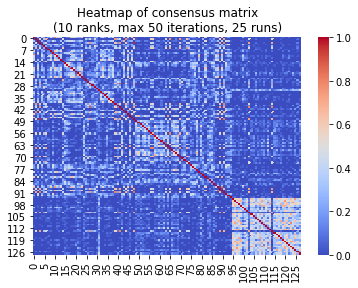

In [ ]:
sns.heatmap(consensus_matrix, cmap='coolwarm')
plt.title(f"Heatmap of consensus matrix\n({ranks} ranks, max {50} iterations, {nr_runs} runs)")
plt.show()

In [ ]:
# !pip install numpy --upgrade

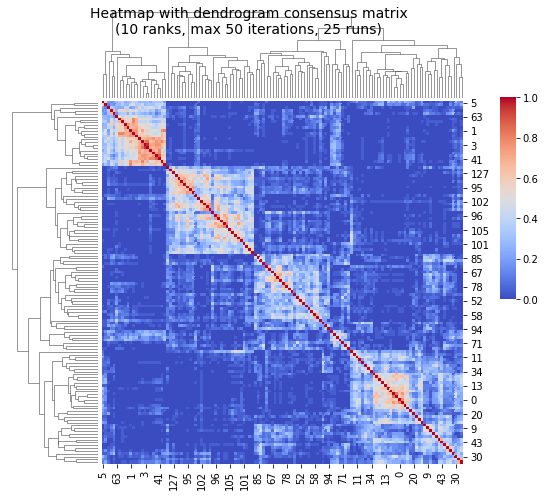

In [ ]:
sns.clustermap(consensus_matrix, cmap='coolwarm', figsize=(7, 7), cbar_pos=(1., .4, .03, .4))
plt.suptitle(f"Heatmap with dendrogram consensus matrix\n({ranks} ranks, max {50} iterations, {nr_runs} runs)\n\n", fontsize=14)
plt.show()

#### 1.3.c) What are the consequences of selecting a rank value that is too small or too large? Implement a method showing how you can optimize the value of the rank to be used.

The rank indicates the number of clusters into which the data will be divided. It defines the size of the new subspace i.e the number of features to be extracted. 
- If the rank is **too low** we will **miss features** and 
- if the rank is **too large** we will **model noise**. 

Hence its important to pick an optimal rank which reduces the noise in the data and effectively models the features.

We can optimise the value of rank by running the NMF algorithm on data and measuring the quality of clustering based on different **quality metrics**. The rank corresponding to the best quality clustering can then be selected.

In [ ]:
# Method to find the optimum rank value using cophenetic correlation coefficient
def get_optimum_rank(candidate_ranks = [8, 10], data = None, quality_metric = 'cophenetic'):
    '''
    This method selects the optimum rank value from the
    list of candidate ranks. The optimum rank value is the rank which
    produces a clustering having the highest value of the quality metric.
    
    Parameters:
    candidate_ranks - The list of candidate ranks which will be tested to find the optimum rank,
    data - The data to be clustered,
    quality_metric - The metric used to asses the quality of the clustering produced by the rank.
    We assess the quality of the clustering using cophenetic correlation 
    '''

    best_rank = candidate_ranks[0]
    quality_metric_results = []
        
    for candidate_rank in candidate_ranks:        
        
        # Perform NMF clustering with the current candidate rank
        nmf_model = nimfa.Nmf(
            V = data.to_numpy(),
            rank = candidate_rank,
            max_iter = max_nr_iterations,
            n_run = nr_runs,
            track_factor=True,
        )
        nmf_fit = nmf_model()
        
        # Choose highest rank before the cophenetic correlation starts dropping
        if ( 0 < len(quality_metric_results) and quality_metric_results[- 1] > nmf_fit.summary()['cophenetic'] ):
            break
        else:
            # Update the best rank since a better one has been found
            best_rank = candidate_rank
            
        quality_metric_results.append(nmf_fit.summary()['cophenetic'])
    
    return best_rank

In [ ]:
ranks_test_list = [2, 3, 10]
_start = time.time()
optimum_ranks = get_optimum_rank(candidate_ranks = ranks_test_list, data = gene_expression_data)
_end = time.time()

print(f"The optimal rank (out of {ranks_test_list}) is {optimum_ranks}")
print(f"(Evaluated {len(ranks_test_list)} rank-candidates in {round(_end-_start, 2)} sec.)")

The optimal rank (out of [2, 3, 10]) is 3
(Evaluated 3 rank-candidates in 27.92 sec.)


#### 1.4. Inform yourself about **Non-Negative Matrix Tri-Factorization** (**NMTF**). What is the primary difference between NMF and NMTF and what does it achieve?

Source: [Non-Negative Matrix Tri-Factorization for co-clustering:
an analysis of the block matrix](https://www.researchgate.net/publication/272923306_Non-negative_Matrix_Tri-Factorization_for_co-clustering_An_analysis_of_the_block_matrix) by *N. Del Buono* and *G. Pio b*

One may desired to have a **co-clustering** method for non-negative dyadic data (that is data representing observations which relate two finite sets).

NMF as a clustering algorithm can be used for co-clustering by demanding $WW^\intercal = \mathbb{I}$ and $HH^\intercal = \mathbb{I}$. 

(This induces that every cluster member is in closer to only one cluster centroid and far from the others -> **Minimize intra-cluster variance and maximize inter-cluster variance**)

However these two constraints are in practise often too restrictive. NMTF can reduce this problem.

**NMTF** approximates a (data) matrix $X\in\mathbb{R}^{n\times m}$ by three non-negative factor matrices 
- $U\in\mathbb{R}_+^{n\times l}$ (row coefficients), 
- $S\in\mathbb{R}_+^{l\times k}$ (block matrix) and 
- $U\in\mathbb{V}_+^{k\times m}$ (column coefficients):
$$ X\approx USV $$

(Generally it is $k\ll \min\{n, m\}$ and $l\ll \min\{n, m\}$

A NMF can be implied by setting $W := US$ and $H:=V$ (and the other way around).

**Primary difference**: 
Factorizing in three instead of two matrices.

**What does it achieve:**
Using NMTF over NMF for co-clustering may lead to a greater (better) average inter-cluster similarity.


#### 1.5. PCA and NMF are both matrix factorization methods, how do they differ from each other? Describe a situation where PCA is favored over NMF.

Sources: 
- [Quora Q&A](https://www.quora.com/When-should-I-use-PCA-versus-non-negative-matrix-factorization) - Dnyaneshwar Giri, Database Developer at Schlumberger
- ["Everything you did and didn't know about PCA"](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/) by Alex Williams, postdoc in Statistics at Stanford University

Principal components (PCs) are linear combinations of uncorrelated attributes (and thus orthogonal to each other). One can order them in terms of variance and represent the other data by a linear combination of them. Thus they are usefull for dimensionality reduction.

While PCA identifies these PCs to segment the data, NMF introduces a **non-negativity constraint** on the coefficients of the linear combination. This forces the reconstructed whole to be an additive combination of the basis pasts, and generally leads to zeros for non-contributing factors.

Situation where PCA is favored over NMF:
- When the data is linearly separable
- When one is encouraged to generade new features
- To establish a geometrical separability between data tuples.
- For classification model building.

---
### Exercise 2 - Machine Learning

#### 2.1. The type of machine learning (e.g. supervised learning, unsupervised learning, etc.) applied depends on the problem at hand. Assume that we have an `Alzheimer's disease (AD) dataset` where rows represent 500 participants and columns represent 100 different collected measurements for each participant.

##### 2.1.a) You are asked to train a model that can predict whether a participant is healthy or AD. Mention the type of machine learning you would use for this case scenario and elaborate.

We would use **supervised learning** because in this dataset we are dealing with labeled samples that we can use to learn how to correctly classify unseen participants. We have a very small amount of data at hand and so it is important that we choose a low-complexity model to not overfit the given data. We are also not interested in the different clusters into which the patients or features can be divided based on the data hence unsupervised learning does not seem appropriate.

##### 2.1.b) Assume that we do not have any information about the diagnosis of each participant. This time we would like to divide our participants into groups based on the features that we have in hand. What type of machine learning would be appropriate for this scenario and elaborate?

In this case we ca not use supervised learning as our samples are not labeled, so we would choose **unsupervised learning** ( eg. hierarchical clustering, k-means clustering, GMMs, NMF). Our goal then is to learn the inherent structure of our samples and find clusters that could then be used to categorize new samples.

##### 2.1.c) Imagine that the shape of our dataset is *(100, 600)*, mention one pre-processing step that you would take to carry out the tasks *2.1.a)* and *2.1.b)*?

The shape of our dataset indicates that we have 100 samples and 600 features. The no. of features in the dataset is very large as compared to samples. To deal with this high dimensional data, we can apply dimensionality reduction technique of Principal Component Analysis as a pre-processing step. We can then select the number of Principal Components to represent our data and apply machine learning tasks (a) and (b) on the selected Principal Components.

- `2.1.a)` We would slice the dataset into two distinct sets, namely a training and a test set. The training set is used to train the supervised learning algorithm we're using. The test set is then used to evaluate the model and is used once the model is trained. We would split the dataset at 500 participants so that we have a training set of size *(100, 500)* and a test set of size *(100, 100)*.

- `2.1.b)` For unsupervised learning in this case we do not need to split the set into training and test set as we want to find the inherent structure of the given data and so it is crucial to have as much data at hand as possible. Also we would not be able to evaluate the model with a test set because there is no way to evaluate the performance without given labels.

#### 2.2. Generate a pipeline in scikit learn using the following code snippet:

In [ ]:
####################### Given Code Snippet ############################
# polynomial_features = PolynomialFeatures(degree=15, include_bias=False)
# linear_regression = LinearRegression()

# pipeline = Pipeline([
#     ("polynomial_features", polynomial_features),
#     ("linear_regression", linear_regression)
# ])`
#######################################################################

In [ ]:
polynomial_features = PolynomialFeatures(degree=15, include_bias=False)
linear_regression = LinearRegression()

pipeline = Pipeline([
  ("polynomial_features", polynomial_features),
  ("linear_regression", linear_regression)
])

##### 2.2.a) Using the Fish dataset provided, identify the quality of fit of the pipeline for the dataset (use the weight as the response variable).

In [ ]:
fish_ds = get_dataset_from_github("Fish.csv")
fish_ds.head(4)

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555


In [ ]:
# Preparation of the training data
y = fish_ds['Weight'].to_numpy()
X = fish_ds.drop(['Weight'], axis=1).to_numpy()
# Replace the species strings with numbers. Should we do this? seems wrong to me as its categorical
# However, we will have to do this to handle the categorical feature "Species" before the data is fed into pipeline
_, X[:,0] = np.unique(X[:,0], return_inverse=True)

In [ ]:
# Train on the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Fit the data
pipeline.fit(X_train, y_train)
y_predicted = pipeline.predict(X_test)

In [ ]:
# Print results
print(f"Score:               {pipeline.score(X_test, y_test)}")
print(f'Explained Variance:  {explained_variance_score(y_test, y_predicted)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_predicted)}')
print(f'R2 Score:            {r2_score(y_test, y_predicted)}')
print(f'Mean Squared Error:  {mean_squared_error(y_test, y_predicted)}')

Score:               -47656136990019.78
Explained Variance:  -45695382578656.23
Mean Absolute Error: 734433808.8446305
R2 Score:            -47656136990019.78
Mean Squared Error:  9.053322170016309e+18


##### 2.2.b) If the pipeline produces a badly fit model for the dataset, list some methods to improve the model.

The model has been a **bad fit** as indicated by explained variance score, mean absolute error, $R^2$ score and mean squared error.


Methods to improve the model are:
- Remove the Polynomial Features preprocessing step from pipeline
- Perform PCA to decorrelate features
- Use regularization techniques and perform Lasso or Ridge Regression

#### 2.3. In this exercise we will compare the accuracy of different methods on a high-dimensional ($p>>n$) dataset. Load the leukemia_small.csv and extract the class labels from the column names (2 classes, `AML` and `ALL`).Randomly split the data into *70%* training and *30%* test.

**Hint:** Use the `train_test_split` function from scikit-learn to define the test_size and
set `random_state=1` for better reproducibility.


In [69]:
leukemia_small_ds = get_dataset_from_github("leukemia_small.csv", index_col_str = False, header_str = None).T.rename(columns={ 0: 'Class'})
leukemia_small_ds.head(4)

,Class,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3532,3533,3534,3535,3536,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546,3547,3548,3549,3550,3551,3552,3553,3554,3555,3556,3557,3558,3559,3560,3561,3562,3563,3564,3565,3566,3567,3568,3569,3570,3571
0,ALL,0.561549117,0.213566469,-0.636584194,0.34712398,0.545508929,1.720234943,1.855733316,1.800898906,0.109674775,-0.288622115,0.172398982,-0.056535636,-0.293796966,-0.753771588,-0.047159955,1.174768572,0.885725999,0.960716855,1.03027837,-0.887742179,0.878236512,-0.072578516,-0.950653716,0.194475476,-0.90126314,-1.403129034,0.08544546,-0.077103259,-0.572644696,-0.019092489,0.356714586,-0.550185015,0.215047891,0.356506114,-1.18939295,-0.601479716,-0.504250677,-0.911922977,0.881435116,...,1.133279972,-1.303194915,-1.22576188,0.274410778,-0.58729919,0.465868103,1.029307754,-0.438912101,0.907392848,0.538989088,0.337721853,-1.153526375,-0.313203102,-0.289005777,-0.748961886,-0.253659787,-0.538890637,-0.641355495,-1.116868354,-0.345541923,0.587859742,-0.034107849,-0.552531313,-0.317909902,0.759793692,0.450235067,0.44186214,0.203262606,1.093257171,0.186078302,0.046676217,0.126566848,0.61284668,0.443501521,0.859034625,-0.672449451,0.150162632,0.068992444,0.129262921,-0.533469501
1,ALL,-0.623141166,-0.912107005,-0.465296101,-0.734344627,-0.539898208,0.000112247,-0.717582533,0.733660606,0.018899509,-0.159572898,-0.055124766,-0.231349506,1.055416294,0.142631039,-0.04609399,0.487989199,0.28087913,0.143566847,1.055985841,0.545802623,0.864516049,0.315409203,-0.016670824,0.095174309,-0.691832691,-0.338084377,-0.029403143,-0.519796335,-0.379407842,0.458945454,-0.18980173,1.144176474,0.448057984,-1.269341546,0.419031407,0.306394172,0.300575436,-0.01875397,0.289719467,...,0.060390202,-0.248578924,-0.645320421,-0.32735125,0.053913756,-0.540641844,-0.495055716,-0.272546852,-0.574711676,-0.053121517,0.812706165,-0.69147496,0.759219606,-0.048362943,-0.553353396,-0.547467817,-0.429311704,-0.713568059,0.666996231,0.347290097,0.528568249,-0.28710694,-0.601236397,-0.371594266,-0.723166263,-0.899579008,0.052185513,0.165260574,-1.698748836,-0.637995963,-0.180748586,-0.146952384,-0.453801419,-0.527682479,-0.457938679,0.41200043,0.392065095,0.054326025,0.007136491,-1.14837176
2,ALL,-0.814523716,-1.084069278,-0.583126554,1.785912462,1.445063581,1.099342014,1.111595335,1.178676098,-0.193477159,-0.116154698,-0.30992514,-0.427120893,1.166872593,-0.772489668,-0.775355902,0.65031595,0.031918602,0.467452308,0.826083031,1.248610248,1.492170857,1.042891715,-1.604553884,0.454315131,-0.118768945,0.777405974,2.193976334,-0.212635641,-0.595666004,0.918900651,1.360256604,0.734339427,0.307071548,-0.126907801,-0.599930318,0.495834684,0.766432741,1.525370772,0.165779243,...,0.3059003,0.685548133,-1.112055292,-1.351322498,-0.589529735,0.081023398,-0.036864317,-0.458732055,-2.435798543,0.409979905,-0.077493032,-1.296028224,0.477144948,-0.917109352,-0.772265739,0.323575094,-0.551945343,-0.626667709,-0.19972538,0.841453206,0.669142032,-0.570436763,-0.777686331,0.916680047,0.460648557,0.814594515,-1.916366345,-1.462125447,1.140758821,-1.281924817,-0.813904039,0.620945453,1.117184336,1.572018162,-0.355646467,0.921389555,-1.207114119,0.479036165,1.546483562,-0.391755427
3,ALL,0.229492381,-0.965718987,-0.525059929,-0.188015918,-0.534602564,1.177446527,1.057922482,1.126832141,0.289005757,-0.085842156,0.380784905,0.126031546,-0.888375551,-0.651474458,-0.145383059,0.760924113,-0.018085432,-0.078384187,0.315194588,-1.253140508,0.201908315,0.701529788,0.969925085,-1.016213958,-0.764904702,0.538379418,1.601447746,-0.418467485,-0.446829774,-0.582513061,0.416560127,0.498936025,0.859670439,0.355850138,-0.29226057,0.155317364,0.004809928,-0.4911139,0.429193484,...,-0.024495203,-1.709761016,1.199066467,0.312304726,-0.366831729,1.364042021,0.050002138,-0.330593059,-0.357428318,0.666813073,0.41078959,0.240791651,-0.380810378,0.205803791,-0.621602811,-0.85444165,-0.467544697,0.6096

In [70]:
X_train, X_test, y_train, y_test = train_test_split(leukemia_small_ds.iloc[:,1:], leukemia_small_ds['Class'], test_size=0.3, random_state=1)

##### 2.3.a) Fit a logistic regression (no penalization)

In [71]:
regr_wo_penalty = LogisticRegression(penalty='none').fit(X_train, y_train)
y_train_predicted_wo_penalty = regr_wo_penalty.predict(X_train)
y_test_predicted_wo_penalty = regr_wo_penalty.predict(X_test)

##### 2.3.b) Fit multiple $l_1$-penalized logistic regressions ($\lambda \in \{ 0.001,\ 0.01,\  0.1,\ 
1,\  10,\ 100\}$)

In [72]:
lambdas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [73]:
regr_l1_penalty =[None] * len(lambdas)
y_train_predicted_l1_penalty  = [None] * len(lambdas)
y_test_predicted_l1_penalty   = [None] * len(lambdas)

for index in range(len(lambdas)):
  regr_l1_penalty[index] = LogisticRegression(penalty='l1', C=1/lambdas[index], solver='liblinear').fit(X_train, y_train)
  y_train_predicted_l1_penalty[index]  = regr_l1_penalty[index].predict(X_train)
  y_test_predicted_l1_penalty[index]   = regr_l1_penalty[index].predict(X_test)

##### 2.3.c) Fit multiple $l_2$-penalized logistic regressions ($\lambda \in \{ 0.001,\ 0.01,\  0.1,\ 
1,\  10,\ 100\}$)

In [74]:
regr_l2_penalty =[None] * len(lambdas)
y_train_predicted_l2_penalty  = [None] * len(lambdas)
y_test_predicted_l2_penalty   = [None] * len(lambdas)

for index in range(len(lambdas)):
  regr_l2_penalty[index] = LogisticRegression(penalty='l2', C=1/lambdas[index]).fit(X_train, y_train)
  y_train_predicted_l2_penalty[index]  = regr_l2_penalty[index].predict(X_train)
  y_test_predicted_l2_penalty[index]   = regr_l2_penalty[index].predict(X_test)

##### 2.3.d) For the models from *2.3.a)*, *2.3.b)*, and *2.3.c)* measure the performance on the training and test set

In [75]:
def print_seperator(mode=0):
  if mode==0:
    print('\n' + 70 * ('-*') + '-' + '\n') 
  else:
    print(4*'\t' + '*' + 50 * ('-') + '*' + '\n')

In [76]:
three_digit_lambdas = ['{:.4}'.format(number) for number in lambdas]
three_digit_lambdas

['0.001', '0.01', '0.1', '1.0', '10.0', '100.0']

In [77]:
print("Classification report of the logistic regression with no penalization on the training set:\n", classification_report(y_train, y_train_predicted_wo_penalty))
print("Classification report of the logistic regression with no penalization on the test set:\n",   classification_report(y_test, y_test_predicted_wo_penalty))

print_seperator()

for index in range(len(lambdas)):
  print("Classification report of the l1 -penalized logistic regressions with lambda equal to %s on the training set:\n" % three_digit_lambdas[index],  classification_report(y_train, y_train_predicted_l1_penalty[index]))
  print("Classification report of the l1 -penalized logistic regressions with lambda equal to %s on the test set:\n" % three_digit_lambdas[index],      classification_report(y_test, y_test_predicted_l1_penalty[index]))
  if index != len(lambdas)-1:
    print_seperator(mode=1)

print_seperator()

for index in range(len(lambdas)):
  print("Classification report of the l2 -penalized logistic regressions with lambda equal to %s on the training set:\n" % three_digit_lambdas[index],  classification_report(y_train, y_train_predicted_l2_penalty[index]))
  print("Classification report of the l2 -penalized logistic regressions with lambda equal to %s on the test set:\n" % three_digit_lambdas[index],      classification_report(y_test, y_test_predicted_l2_penalty[index]))
  if index != len(lambdas)-1:
    print_seperator(mode=1)    

Classification report of the logistic regression with no penalization on the training set:
               precision    recall  f1-score   support

         ALL       1.00      1.00      1.00        33
         AML       1.00      1.00      1.00        17

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

Classification report of the logistic regression with no penalization on the test set:
               precision    recall  f1-score   support

         ALL       1.00      0.79      0.88        14
         AML       0.73      1.00      0.84         8

    accuracy                           0.86        22
   macro avg       0.86      0.89      0.86        22
weighted avg       0.90      0.86      0.87        22


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Classification report 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 2.3.e) Using *2.3.d)* report the performances with one scatterplot for each approach (one scatterplot for each: unpenalized, $l_1$, $l_2$), with the regularization constant on the $x$-axis and the accuracy on the $y$-axis, train and test set colored differently, proper axis labels and a legend.

Text(0, 0.5, 'Accuracy')

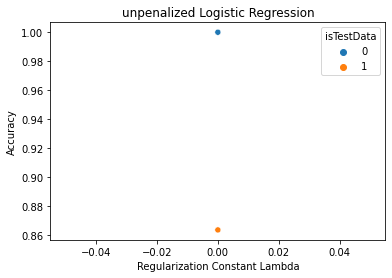

In [78]:
unpen_results_dataframe = pd.DataFrame([[0, regr_wo_penalty.score(X_train, y_train), 0], 
                                        [0, regr_wo_penalty.score(X_test, y_test), 1]], 
                                       columns = ['lambda', 'accuracy', 'isTestData'])

sns.scatterplot(x = 'lambda', y = 'accuracy', data = unpen_results_dataframe, hue = 'isTestData')
plt.title('unpenalized Logistic Regression')
plt.xlabel('Regularization Constant Lambda')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

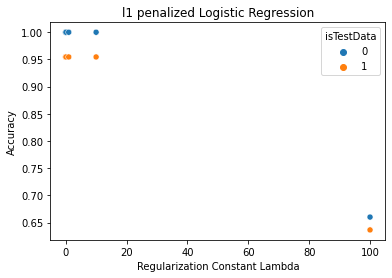

In [79]:
train_results_list = list(zip(lambdas,  [model.score(X_train, y_train) for model in regr_l1_penalty], [0] * len(lambdas)))
test_results_list = list(zip(lambdas,   [model.score(X_test, y_test) for model in regr_l1_penalty],   [1] * len(lambdas)))
l1_results_dataframe = pd.DataFrame(train_results_list + test_results_list, columns = ['lambda', 'accuracy', 'isTestData'])

sns.scatterplot(x = 'lambda', y = 'accuracy', data = l1_results_dataframe, hue = 'isTestData')
plt.title('l1 penalized Logistic Regression')
plt.xlabel('Regularization Constant Lambda')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

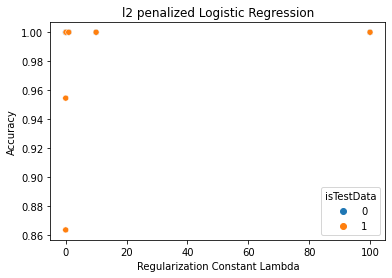

In [80]:
train_results_list = list(zip(lambdas,  [model.score(X_train, y_train) for model in regr_l2_penalty], [0] * len(lambdas)))
test_results_list = list(zip(lambdas,   [model.score(X_test, y_test) for model in regr_l2_penalty],   [1] * len(lambdas)))
l2_results_dataframe = pd.DataFrame(train_results_list + test_results_list, columns = ['lambda', 'accuracy', 'isTestData'])

sns.scatterplot(x = 'lambda', y = 'accuracy', data = l2_results_dataframe, hue = 'isTestData')
plt.title('l2 penalized Logistic Regression')
plt.xlabel('Regularization Constant Lambda')
plt.ylabel('Accuracy')

##### 2.3.f) Which method in combination with which parameter gives the best results on the test set?

The best results on the test set are obtained by using penalized Logistic Regression models. By analysing the classification report containing precision, recall and f1 score, it can be seen that the **l1 penalized Logistic Regression** algorithm performs perfect classification with **lambda = 0.1** and the **l2 penalized Logistic Regression** performs perfect classification with **lambda=0.1, 1, 10, 100**.